# Overview

In this notebook we will cover a variety of different schemes in order to determine the optimal number of clusters:
- Gap Statistic
- Elbow Method
- Gaussian Mixture Model (AIC and BIC)
- Silhoutte Method 
- Calinski Criterion

# Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

## Arbitrary Data Creation

In [348]:
X, y = make_blobs(n_samples=10000, centers=[[0,0],[0,2],[3,0]], n_features=2,random_state=0)

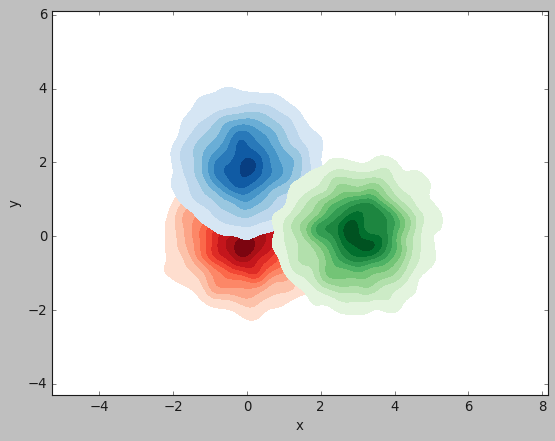

In [349]:
X1_dataframe = pd.DataFrame(X[y==0],columns=["x","y"])
X2_dataframe = pd.DataFrame(X[y==1],columns=["x","y"])
X3_dataframe = pd.DataFrame(X[y==2],columns=["x","y"])

fig, ax = plt.subplots()
ax.axis('equal')
ax = sns.kdeplot(X1_dataframe.x,X1_dataframe.y, cmap="Reds", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X2_dataframe.x,X2_dataframe.y, cmap="Blues", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X3_dataframe.x,X3_dataframe.y, cmap="Greens", shade=True, shade_lowest=False, ax=ax)

# Gap Statistic

## Designing $W_k$

$$W_k = \sum\limits^k_{r=1}\frac{1}{n_r}D_r$$

We first need to compute the pooled within-cluster sum of squares around the cluster means

In [175]:
# Training the models
k_means_algos_down = []

ks = list(range(1,7))
for k in ks:
    print(k)
    kmeans = KMeans(init='k-means++',n_clusters = k,n_init=10,verbose=3,n_jobs=-1,random_state=0)
    kmeans.fit(X)
    k_means_algos_down.append(kmeans)

1
2
3
4
5
6


In [176]:
k_means_algos_down[2].inertia_ #Calculating the Inertia

15712.955120954583

In [177]:
k=3
means = k_means_algos_down[2].cluster_centers_
clusters = np.array([X[k_means_algos_down[2].labels_==i] for i in range(k)])

##Example for Visualizing the Data

# plt.scatter(clusters[0][:,0],clusters[0][:,1],c='b')
# plt.scatter(means[0][0],means[0][1],c='r')

In [178]:
def W_k(clusters):
    total=0
    for i in range(len(clusters)):
        D = pairwise_distances(clusters[i])
        total += np.sum(D)/(2*len(clusters[i]))
    return total

In [182]:
total=W_k(clusters)

In [181]:
W_ks = []
for j in range(6):
    clusters = np.array([X[k_means_algos_down[j].labels_==i] for i in range(j+1)])
    W_ks.append(W_k(clusters))

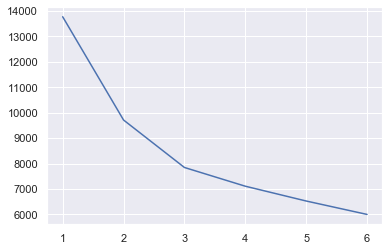

In [184]:
plt.figure();plt.title("Internal Sum of Squares")
plt.plot(list(range(1,7)),W_ks)

## Generating a Uniform Sample

In [ ]:
def bounding_dimensions(X):
    dimension_ranges = []
    for i in range(X.shape[1]):
        dimension_ranges.append([min(X[:,i]),max(X[:,i])])
    return np.array(dimension_ranges)

def generating_uniform_over_variables(ranges,size=1000):
    return np.array([np.random.uniform(low=r[0],high=r[1],size=size) for r in ranges]).T

In [199]:
dimensions = bounding_dimensions(X)

In [200]:
uniform_sample = generating_uniform_over_variables(dimensions,size=10000)

In [201]:
uniform_sample.shape

(10000, 2)

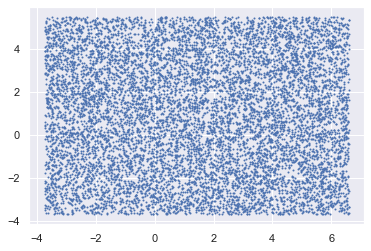

In [202]:
plt.scatter(uniform_sample[:,0],uniform_sample[:,1],s=1)

In [244]:
# Training the models
uniform_k_means_algos_down = []

ks = list(range(1,7))
for k in ks:
    print(k)
    kmeans = KMeans(init='k-means++',n_clusters = k,n_init=10,verbose=3,n_jobs=-1)
    kmeans.fit(uniform_sample)
    uniform_k_means_algos_down.append(kmeans)

1
2
3
4
5
6


In [245]:
W_ks_star = []
for j in range(6):
    clusters = np.array([uniform_sample[uniform_k_means_algos_down[j].labels_==i] for i in range(j+1)])
    W_ks_star.append(W_k(clusters))

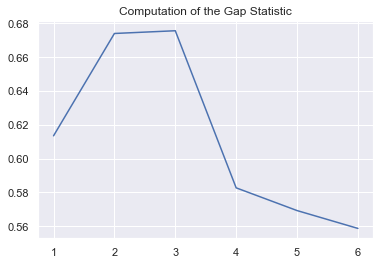

In [246]:
plt.figure();plt.title("Computation of the Gap Statistic")
plt.plot(list(range(1,7)),np.log(W_ks_star)-np.log(W_ks))

## Overall putting all the steps together we get

In [301]:
def creating_classifiers(max_number_clusters,train_data,random_state=0):
    k_means_algos = []
    ks = list(range(1,max_number_clusters+1))
    for k in ks:
        print(k)
        kmeans = KMeans(init='k-means++',n_clusters = k,n_init=10,verbose=3,n_jobs=-1,random_state=random_state)
        kmeans.fit(train_data)
        k_means_algos.append(kmeans)
    return k_means_algos

def W_k(clusters):
    total=0
    for i in range(len(clusters)):
        D = pairwise_distances(clusters[i])
        total += np.sum(D)/(2*len(clusters[i]))
    return total

def calculation_of_W_ks(max_number_clusters,X):
    output = []
    classifiers = creating_classifiers(max_number_clusters,X)
    for i in range(max_number_clusters-1):
        clusters = np.array([X[classifiers[i].labels_==j] for j in range(i+1)])
        output.append(W_k(clusters))
                      
    return np.array(output)
                      
def bounding_dimensions(X):
    dimension_ranges = []
    for i in range(X.shape[1]):
        dimension_ranges.append([min(X[:,i]),max(X[:,i])])
    return np.array(dimension_ranges)

def generating_uniform_over_variables(ranges,size=1000):
    return np.array([np.random.uniform(low=r[0],high=r[1],size=size) for r in ranges]).T

def calculation_of_W_ks_star(max_number_clusters,X,random_state=0):
    """
    Input
    -----
    
    X: (number of samples, dimension of samples)
    
    """
    output = []
    dimension_ranges = bounding_dimensions(X)
    uniform_sample = generating_uniform_over_variables(dimension_ranges,size=len(X))
    
    classifiers = creating_classifiers(max_number_clusters,uniform_sample,random_state=random_state)
    
    for i in range(max_number_clusters-1):
        clusters = np.array([uniform_sample[classifiers[i].labels_==j] for j in range(i+1)])
        output.append(W_k(clusters))
                      
    return np.array(output)

def calculation_of_log_W_ks_star_B(max_number_clusters,X,B):
    B_simulations = np.array([np.log(calculation_of_W_ks_star(max_number_clusters,X,random_state=i)) for i in range(B)])
    B_means = np.mean(B_simulations,axis=0)
    
    return B_means

def calculation_of_log_W_ks(max_number_clusters,X):
    return np.log(calculation_of_W_ks(max_number_clusters,X))

def calculation_of_log_W_ks_star_B_A(max_number_clusters,X,B):
    B_simulations = np.array([np.log(calculation_of_W_ks_star(max_number_clusters,X,random_state=i)) for i in range(B)])
    B_means = np.mean(B_simulations,axis=0)
    
    #Calculating Standard Deviation
    sd_k = np.power(np.mean([np.power((B_simulations[i]-B_means),2) for i in range(B)],axis=0),0.5)
    s_k = sd_k*np.power(1+1/B,0.5)
    
    return B_means,s_k

In [284]:
calc = calculation_of_W_ks(7,X)

1
2
3
4
5
6
7


In [285]:
calc

array([13768.16801474,  9711.65755386,  7846.85398111,  7110.97121689,
        6524.24391899,  6002.75111985])

In [282]:
calc_star = calculation_of_W_ks_star(7,X,random_state=0)

1
2
3
4
5
6
7


In [280]:
calc_star

array([25499.02125233, 19183.69738416, 15499.05295427, 12642.22710006,
       11484.67178967])

In [277]:
W_ks_star

[25428.552823850743,
 19055.30735105164,
 15421.285408635673,
 12735.36801814428,
 11538.182175448377,
 10495.604333168907]

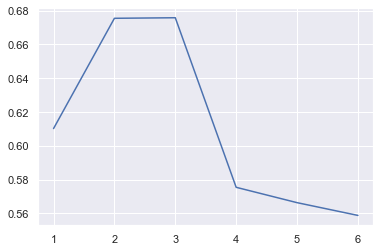

In [286]:
plt.plot(list(range(1,7)),np.log(calc_star)-np.log(calc))

## The Gap Statistic as a whole

For this Gap Statistic now we need to follow the following steps:
- Cluster the observed data, varying the total number of clusters from $k=1,2,\dots,K$ giving within-dispersion measures $W_k$,$k=1,2,\dots,K$.
- Generate B reference sets, using the uniform prescription (a) or (b) above, and cluster each one giving within-dispersion measures $W^*_{kb}$, $b=1,2,\dots,B$, $k=1,2,\dots,K$
- Then we are going to have to have to have $\bar{l} = (1/B)\sum_{b}\log(W^*_{kb})$, computing the standard deviation gives us:
$$sd_k = [(1/B)\sum_b[\log(W^*_{kb})-\bar{l}]^2]^{1/2}$$
then we need to define $s_k = sd_k \sqrt{1+1/B}$. Then we choose the number of clusters via:
$$\hat{k} = \text{smallest k such that Gap(k)}\geq \text{Gap(k+1)}-s_{k+1}$$

## Testing Validity

### Three Obvious Blobs

In [309]:
X, y = make_blobs(n_samples=10000, centers=[[0,0],[0,3],[3,0]], n_features=2,random_state=0)

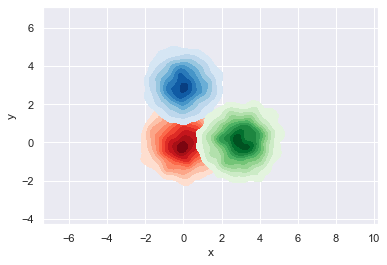

In [313]:
X1_dataframe = pd.DataFrame(X[y==0],columns=["x","y"])
X2_dataframe = pd.DataFrame(X[y==1],columns=["x","y"])
X3_dataframe = pd.DataFrame(X[y==2],columns=["x","y"])

fig, ax = plt.subplots()
ax.axis('equal')
ax = sns.kdeplot(X1_dataframe.x,X1_dataframe.y, cmap="Reds", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X2_dataframe.x,X2_dataframe.y, cmap="Blues", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X3_dataframe.x,X3_dataframe.y, cmap="Greens", shade=True, shade_lowest=False, ax=ax)

In [310]:
calc = calculation_of_log_W_ks(7,X)

1
2
3
4
5
6
7


In [311]:
calc_star, s_k = calculation_of_log_W_ks_star_B_A(7,X,5)

1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7


<ErrorbarContainer object of 3 artists>

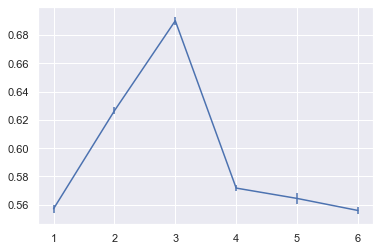

In [312]:
plt.errorbar(range(1,7),calc_star-calc,yerr=s_k)

### Three Less Obvious Blobs

In [ ]:
X, y = make_blobs(n_samples=10000, centers=[[0,0],[0,2],[3,0]], n_features=2,random_state=0)

X1_dataframe = pd.DataFrame(X[y==0],columns=["x","y"])
X2_dataframe = pd.DataFrame(X[y==1],columns=["x","y"])
X3_dataframe = pd.DataFrame(X[y==2],columns=["x","y"])

fig, ax = plt.subplots()
ax.axis('equal')
ax = sns.kdeplot(X1_dataframe.x,X1_dataframe.y, cmap="Reds", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X2_dataframe.x,X2_dataframe.y, cmap="Blues", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X3_dataframe.x,X3_dataframe.y, cmap="Greens", shade=True, shade_lowest=False, ax=ax)

In [316]:
calc = calculation_of_log_W_ks(7,X)

1
2
3
4
5
6
7


In [317]:
calc_star, s_k = calculation_of_log_W_ks_star_B_A(7,X,5)

1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7


<ErrorbarContainer object of 3 artists>

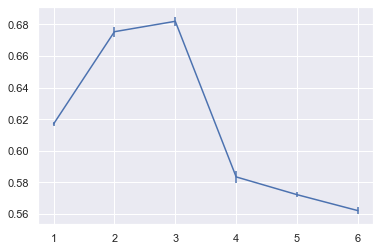

In [318]:
plt.errorbar(range(1,7),calc_star-calc,yerr=s_k)

# Elbow Method

## Initializing Data

### Three Obvious Blobs

In [342]:
X, y = make_blobs(n_samples=10000, centers=[[0,0],[0,3],[3,0]], n_features=2,random_state=0)

X1_dataframe = pd.DataFrame(X[y==0],columns=["x","y"])
X2_dataframe = pd.DataFrame(X[y==1],columns=["x","y"])
X3_dataframe = pd.DataFrame(X[y==2],columns=["x","y"])

fig, ax = plt.subplots()
ax.axis('equal')
ax = sns.kdeplot(X1_dataframe.x,X1_dataframe.y, cmap="Reds", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X2_dataframe.x,X2_dataframe.y, cmap="Blues", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X3_dataframe.x,X3_dataframe.y, cmap="Greens", shade=True, shade_lowest=False, ax=ax)

1
2
3
4
5
6
7


Text(0, 0.5, 'Inertia')

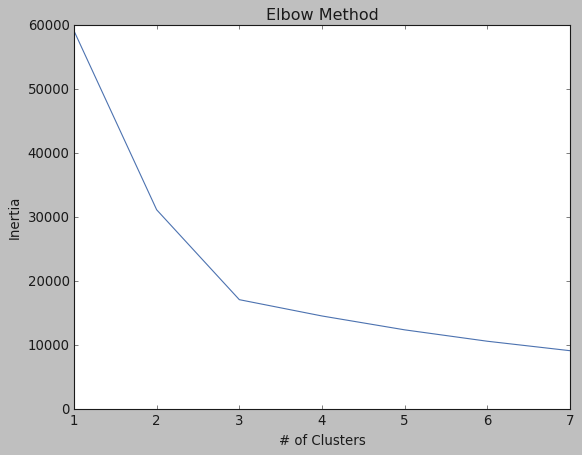

In [343]:
plt.title("Elbow Method")
plt.style.use('classic')
plt.plot(range(1,8),[classifier.inertia_ for classifier in creating_classifiers(7,X,random_state=0)])
plt.xlabel("# of Clusters")
plt.ylabel("Inertia")

### Three Less Obvious Blobs

In [346]:
X, y = make_blobs(n_samples=10000, centers=[[0,0],[0,2],[3,0]], n_features=2,random_state=0)

X1_dataframe = pd.DataFrame(X[y==0],columns=["x","y"])
X2_dataframe = pd.DataFrame(X[y==1],columns=["x","y"])
X3_dataframe = pd.DataFrame(X[y==2],columns=["x","y"])

fig, ax = plt.subplots()
ax.axis('equal')
ax = sns.kdeplot(X1_dataframe.x,X1_dataframe.y, cmap="Reds", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X2_dataframe.x,X2_dataframe.y, cmap="Blues", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X3_dataframe.x,X3_dataframe.y, cmap="Greens", shade=True, shade_lowest=False, ax=ax)

1
2
3
4
5
6
7


Text(0, 0.5, 'Inertia')

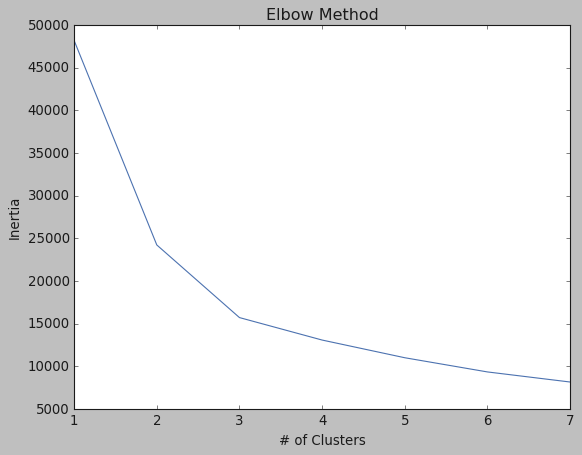

In [347]:
plt.title("Elbow Method")
plt.style.use('classic')
plt.plot(range(1,8),[classifier.inertia_ for classifier in creating_classifiers(7,X,random_state=0)])
plt.xlabel("# of Clusters")
plt.ylabel("Inertia")

# Gaussian Mixture Model

In [395]:
from sklearn.mixture import GaussianMixture

Bayesian Information Criterion: https://en.wikipedia.org/wiki/Bayesian_information_criterion

Akaike Information Criterion: https://en.wikipedia.org/wiki/Akaike_information_criterion

## Initializing the Data

In [365]:
X, y = make_blobs(n_samples=10000, centers=[[0,0],[0,5],[5,0]], n_features=2,random_state=0)

X1_dataframe = pd.DataFrame(X[y==0],columns=["x","y"])
X2_dataframe = pd.DataFrame(X[y==1],columns=["x","y"])
X3_dataframe = pd.DataFrame(X[y==2],columns=["x","y"])

fig, ax = plt.subplots()
ax.axis('equal')
ax = sns.kdeplot(X1_dataframe.x,X1_dataframe.y, cmap="Reds", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X2_dataframe.x,X2_dataframe.y, cmap="Blues", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X3_dataframe.x,X3_dataframe.y, cmap="Greens", shade=True, shade_lowest=False, ax=ax)

## Training GMM

In [ ]:
n_components = np.arange(1,20)

models = [GaussianMixture(n,covariance_type='full',random_state=0).fit(X) for n in n_components]

## Bayesian Information Criterion (BIC)

([<matplotlib.axis.XTick at 0x204939af4c8>,
 <a list of 19 Text xticklabel objects>)

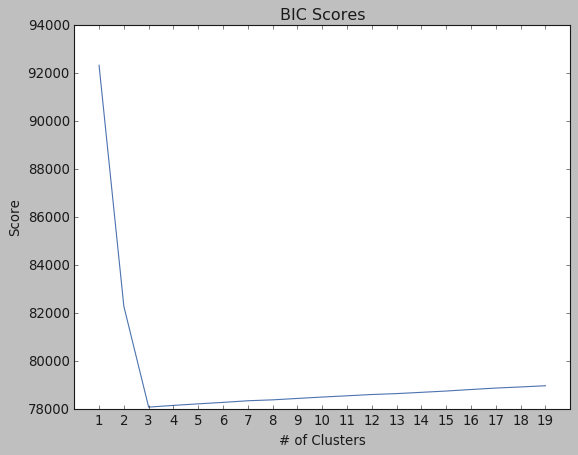

In [370]:
plt.plot(n_components,[m.bic(X) for m in models], label='BIC')
plt.title("BIC Scores")
plt.ylabel("Score")
plt.xlabel("# of Clusters")
plt.xticks(np.arange(1,20)) 

## Akaike Information Criterion

([<matplotlib.axis.XTick at 0x20493a46bc8>,
 <a list of 19 Text xticklabel objects>)

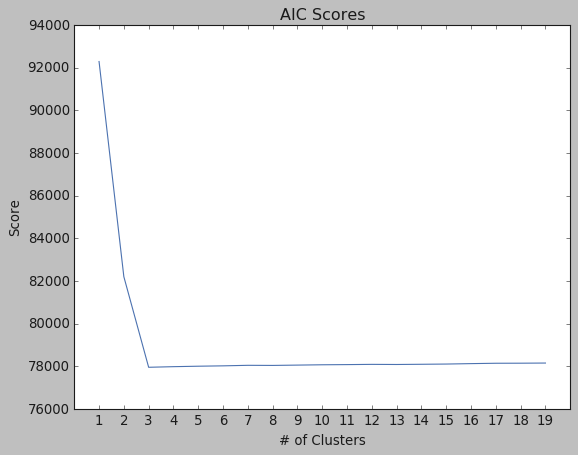

In [371]:
plt.plot(n_components,[m.aic(X) for m in models], label='AIC')
plt.title("AIC Scores")
plt.ylabel("Score")
plt.xlabel("# of Clusters")
plt.xticks(np.arange(1,20)) 

# Silhoutte Method 

In [372]:
from sklearn import metrics

## Initializing the Data

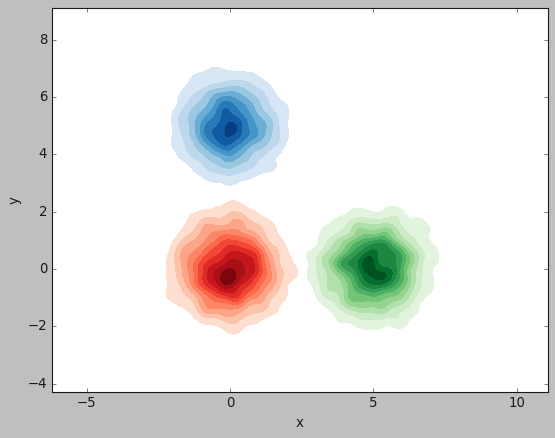

In [374]:
X, y = make_blobs(n_samples=10000, centers=[[0,0],[0,5],[5,0]], n_features=2,random_state=0)

X1_dataframe = pd.DataFrame(X[y==0],columns=["x","y"])
X2_dataframe = pd.DataFrame(X[y==1],columns=["x","y"])
X3_dataframe = pd.DataFrame(X[y==2],columns=["x","y"])

fig, ax = plt.subplots()
ax.axis('equal')
ax = sns.kdeplot(X1_dataframe.x,X1_dataframe.y, cmap="Reds", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X2_dataframe.x,X2_dataframe.y, cmap="Blues", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X3_dataframe.x,X3_dataframe.y, cmap="Greens", shade=True, shade_lowest=False, ax=ax)

## Initializing Classifiers

In [378]:
classifiers = creating_classifiers(7,X,random_state=0)

1
2
3
4
5
6
7


In [381]:
silhouette = [metrics.silhouette_score(X,classifier.labels_) for classifier in classifiers[1:]]

Text(0, 0.5, 'Silhouette Score')

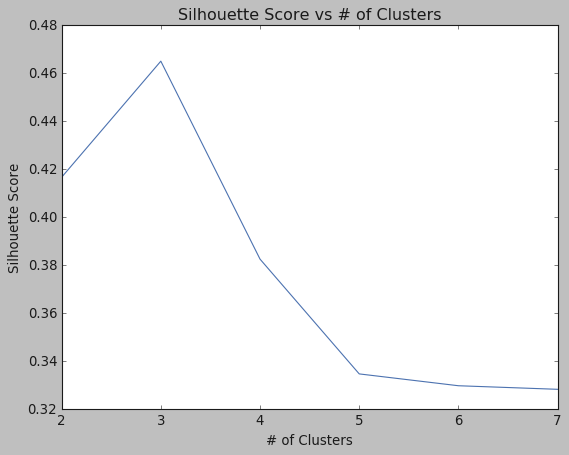

In [388]:
plt.plot(range(2,8),silhouette)
plt.title("Silhouette Score vs # of Clusters")
plt.xlabel("# of Clusters")
plt.ylabel("Silhouette Score")

# Calinski Criterion

## Initializing the Data

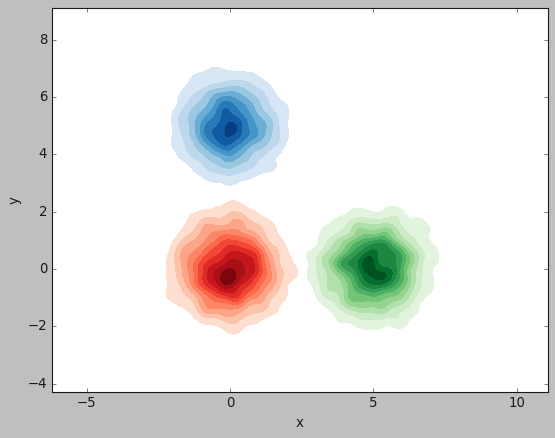

In [389]:
X, y = make_blobs(n_samples=10000, centers=[[0,0],[0,5],[5,0]], n_features=2,random_state=0)

X1_dataframe = pd.DataFrame(X[y==0],columns=["x","y"])
X2_dataframe = pd.DataFrame(X[y==1],columns=["x","y"])
X3_dataframe = pd.DataFrame(X[y==2],columns=["x","y"])

fig, ax = plt.subplots()
ax.axis('equal')
ax = sns.kdeplot(X1_dataframe.x,X1_dataframe.y, cmap="Reds", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X2_dataframe.x,X2_dataframe.y, cmap="Blues", shade=True, shade_lowest=False, ax=ax)
ax = sns.kdeplot(X3_dataframe.x,X3_dataframe.y, cmap="Greens", shade=True, shade_lowest=False, ax=ax)

## Initializing Classifiers

In [390]:
classifiers = creating_classifiers(7,X,random_state=0)

1
2
3
4
5
6
7


In [392]:
ch_score = [metrics.calinski_harabasz_score(X,classifier.labels_) for classifier in classifiers[1:]]

Text(0, 0.5, 'CH Score')

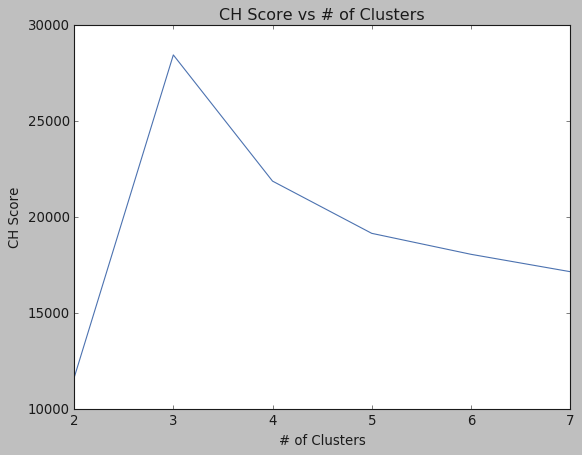

In [394]:
plt.plot(range(2,8),ch_score)
plt.title("CH Score vs # of Clusters")
plt.xlabel("# of Clusters")
plt.ylabel("CH Score")